In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import struct
import pandas as pd
import scipy
from scipy.signal import find_peaks
from matplotlib import colors
from matplotlib import ticker
import matplotlib as mpl
import requests, zipfile
import io
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.fft import fft, fftfreq

**To extract other runs:**

Check the following link: https://docs.google.com/spreadsheets/d/1M0jMwS33TttGbs-REGRAopI9uiohMjcxCvUPJjYtd2g/edit?gid=1816173087#gid=1816173087

To find the run files you wish to extract.

Then, log into a DUNE machine. Instruction for how to do it and extract runs are at the bottom of this page.

# Plan:

datn - neutron source active

datc - cosmics only

data (X) - datn + datc

label (y) - 1 for datn and 0 for datc

X -> transform to features

train test split

run a model - classifier using sklearn

fit - train

evaluate on test

Next Steps:

- Run on different segments of data: try to understand if the classification works well for outlayers too.

- Try different features

- Try different models - random forest, SVM with RBF kernek, ensemble methods and so on.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
def substract_peds(row):
    return row - np.argmax(np.bincount(row))

In [ ]:
# filename2 = '/content/drive/MyDrive/lab_adi/adc_data_run_25087_ch_37_all.npy'
# cdata = cp.load(filename2, mmap_mode='r').astype(cp.int16)

# filename3 = '/content/drive/MyDrive/lab_adi/adc_data_run_25050_ch_37_all.npy'
# ndata = cp.load(filename3, mmap_mode='r').astype(cp.int16)



In [ ]:
from scipy.signal import find_peaks
import gc

def filter_rows(data, param, threshold=0, window_size=0):
  print(data.shape[0])
  print(data.shape[1])
  filtered_data = []
  peak_data = []
  for row in data:
      row = substract_peds(row)
      if 400 < np.max(row) < 12.5e3:
          filtered_data.append(row)
  filtered_data = np.array(filtered_data)
  print(filtered_data.shape[0])
  print(filtered_data.shape[1])
  del data
  gc.collect()
  for row in filtered_data:
    if param == 1:
      index_range = slice(100, 1900)
      peaks, _ = find_peaks(row[index_range], height=100)
      peaks = peaks + index_range.start
    else:
      index_range = slice(100, 52000)
      peaks, _ = find_peaks(row[index_range], height=100)
      peaks = peaks + index_range.start
    print(len(peaks))
    for i, peak in enumerate(peaks):
      if peak in (0, len(row) - 1) or (i > 0 and peaks[i - 1] == peak - 1) or (i < len(peaks) - 1 and peaks[i + 1] == peak + 1):
        continue
      threshold = 0.1 * row[peak]
      left_edge_ind = peak
      while left_edge_ind > max(0, peak-100) and row[left_edge_ind] > threshold:
        left_edge_ind -= 1
      right_edge_ind = peak
      while right_edge_ind < min(len(row)-1, peak+100) and row[right_edge_ind] > threshold:
        right_edge_ind += 1
      if row[left_edge_ind] <= threshold and row[right_edge_ind] <= threshold:
        peak_data.append(row[left_edge_ind:right_edge_ind])
  print(len(peak_data))
  del filtered_data
  gc.collect()
  return peak_data

In [ ]:
def load_in_chunks(filename, chunk_size, param, upper_limit = None):
    data = np.load(filename, mmap_mode='r').astype(np.int16)
    data[data < 0] = 0
    data = filter_rows(data, param)
    plt.plot(data[0])
    plt.show()
    plt.plot(data[40])
    plt.show()
    plt.plot(data[50])
    plt.show()
    plt.plot(data[70])
    plt.show()
    total_size = len(data)
    for start in range(0, total_size, chunk_size):
        end = min(start + chunk_size, total_size) if upper_limit is None else min(start + chunk_size, upper_limit, total_size)
        chunk = pd.DataFrame(data[start:end])
        chunk = chunk[(chunk != 0).any(axis=1)]
        if not chunk.empty:
            yield chunk

In [ ]:
!pip install ipdb
import ipdb
from scipy.signal import find_peaks, chirp, peak_widths

def prompt_fraction(data):
    prompt_fraction = []
    all_values = []
    for i in range(len(data)):
        signal = data[i][~np.isnan(data[i])]
        peak_index = np.argmax(signal)
        width = peak_widths(signal, [peak_index], rel_height=0.35)[0]
        eall = len(signal)
        bprompt = np.argmax(np.gradient(signal))
        endprompt = int(peak_index + width[0]/ 2)
        endprompt = min(endprompt, eall - 1)
        pr = signal[bprompt:endprompt]
        pr = pr[pr > 0]
        ali = signal[bprompt:eall]
        ali = ali[ali > 0]
        prompt_fraction.append(np.sum(pr) / np.sum(ali))
        all_values.append(np.sum(ali))
        if np.sum(pr) / np.sum(ali) == 1:
          plt.plot(data[i])
          plt.show()
          ipdb. set_trace()

    return np.array(prompt_fraction), np.array(all_values)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.2 MB/s eta 0:00:00


In [ ]:
from scipy.signal import find_peaks, chirp, peak_widths

def prompt_fraction_around_peak(data):
    prompt_fraction = []
    all_values = []
    for row in data:
        row = row[~np.isnan(row)]
        eall = len(row)
        peak_index = np.argmax(row)
        rising_edge = np.argmax(np.gradient(row))
        width = peak_widths(row, [peak_index], rel_height=0.3)[0]
        l = (width[0] / 2).astype(int)
        #l = ((peak_index-rising_edge) / 2).astype(int)
        bprompt = max(0, peak_index - l)
        endprompt = min(eall, peak_index + l)
        pr = row[bprompt:endprompt]
        pr = pr[pr > 0]

        ali = row[0:eall]
        ali = ali[ali > 0]

        prompt_fraction.append(np.sum(pr) / np.sum(ali))
        all_values.append(np.sum(ali))

    return np.array(prompt_fraction), all_values

In [ ]:

def prompt_fraction_v(data, r1):
    prompt_fraction = []
    all = []

    for i in range(len(data)):
        signal = data[i][~np.isnan(data[i])]
        rising_edge = np.argmax(np.gradient(signal))
        bprompt, endprompt  = rising_edge+10, rising_edge+ r1
        eall = len(signal)
        pr = signal[bprompt:endprompt]
        pr = pr[pr > 0]
        ali = signal[bprompt:eall]
        ali = ali[ali > 0]
        prompt_fraction.append( np.sum(pr)/ np.sum(ali))
        all.append(np.sum(ali))


    return np.array(prompt_fraction), np.array(all)

In [ ]:
from sklearn.utils import resample

def Bootstrap(data):
    n_iterations = len(data)
    sample_size = len(data)
    bootstrapped_variances = []
    for i in range(n_iterations):
        sample = resample(data, n_samples=sample_size)
        sample_variance = np.var(sample, ddof=1)
        bootstrapped_variances.append(sample_variance)
    bootstrapped_variances = np.array(bootstrapped_variances)
    return bootstrapped_variances

In [ ]:
def features_extraction(df):
    # From all these features, the ones actually used were only the first 3.
    # We should test whether the classification works better with other set of parameters, from the following or others.
    X = df.values
    PromptFraction = prompt_fraction(X)[0]
    PeakPrompt = prompt_fraction_around_peak(X)[0]
    vPrompt = prompt_fraction_v(X, 50)[0]

    PromptFraction_Peak_Dif = PromptFraction - PeakPrompt
    PromptFraction_vPrompt_Dif = PromptFraction - vPrompt
    Peak_vPrompt_Dif = PeakPrompt - vPrompt

    PromptFraction_Peak_Plus = PromptFraction + PeakPrompt
    PromptFraction_vPrompt_Plus = PromptFraction + vPrompt
    Peak_vPrompt_Plus = PeakPrompt + vPrompt

    PromptFraction_Var = Bootstrap(PromptFraction)
    Peak_Var = Bootstrap(PeakPrompt)
    vPrompt_Var = Bootstrap(vPrompt)

    PromptFraction_Peak_Mult = PromptFraction*PeakPrompt
    PromptFraction_vPrompt_Mult = PromptFraction*vPrompt
    Peak_vPrompt_Mult = PeakPrompt*vPrompt

    PromptFraction_2 = PromptFraction*PromptFraction
    PeakPrompt_2 = PeakPrompt*PeakPrompt
    Promptv_2 = vPrompt*vPrompt

    PromptFraction_3 = PromptFraction**3
    PeakPrompt_3 = PeakPrompt**3
    Promptv_3 = vPrompt**3

    Diff_All = -PromptFraction -PeakPrompt -vPrompt
    Plus_All = PromptFraction + PeakPrompt + vPrompt
    Mult_All = PromptFraction*PeakPrompt*vPrompt

    #Create dataframe from features

    data = {
    'PromptFraction': PromptFraction,
    'PeakPrompt': PeakPrompt,
    'V_PROMPT': vPrompt,
    'PromptFraction_Peak_Dif': PromptFraction_Peak_Dif,
    'PromptFraction_vPrompt_Dif': PromptFraction_vPrompt_Dif,
    'Peak_vPrompt_Dif': Peak_vPrompt_Dif,
    'PromptFraction_Var': PromptFraction_Var,
    'vPrompt_Var': vPrompt_Var,
    'Peak_Var': Peak_Var,
    'PromptFraction_Peak_Plus': PromptFraction_Peak_Plus,
    'PromptFraction_vPrompt_Plus': PromptFraction_vPrompt_Plus,
    'Peak_vPrompt_Plus': Peak_vPrompt_Plus,
    'PromptFraction_Peak_Mult': PromptFraction_Peak_Mult,
    'PromptFraction_vPrompt_Mult': PromptFraction_vPrompt_Mult,
    'Peak_vPrompt_Mult': Peak_vPrompt_Mult,
    'PromptFraction_2': PromptFraction_2,
    'PeakPrompt_2': PeakPrompt_2,
    'Promptv_2': Promptv_2,
    'Diff_All': Diff_All,
    'Plus_All': Plus_All,
    'Mult_All': Mult_All,
    'PromptFraction_3': PromptFraction_3,
    'PeakPrompt_3': PeakPrompt_3,
    'Promptv_3': Promptv_3
    }
    # Create a DataFrame
    df_features = pd.DataFrame(data)
    return df_features

Streaming output truncated to the last 5000 lines.
0
0
0
0
0
0
11
13
0
0
0
10
0
0
0
14
0
0
0
0
0
0
0
0
6
0
0
0
0
0
0
0
0
0
0
0
0
0
0
26
0
4
9
0
0
0
0
0
0
0
0
2
0
0
0
0
0
4
1
0
0
0
2
0
0
0
0
0
0
0
7
8
23
21
41
12
31
12
27
23
0
1
20
24
0
3
1
0
44
40
54
10
1
32
0
9
0
4
10
0
54
13
28
27
0
19
9
50
34
16
34
25
0
20
31
93
21
6
23
17
4
30
0
12
14
9
4
18
2
39
23
11
12
19
14
15
25
17
19
29
11
17
48
22
5
10
47
34
25
26
34
18
18
12
9
25
3
27
48
23
4
41
5
2
22
7
29
0
16
35
30
4
0
14
28
22
5
6
31
7
53
22
16
36
1
8
22
69
3
0
32
1
0
38
17
32
20
34
16
15
36
15
31
15
39
32
0
14
57
0
0
1
7
0
13
15
9
5
13
11
16
5
21
22
6
13
4
25
76
2
67
21
0
0
62
15
4
4
0
12
9
15
3
42
24
3
46
0
11
0
35
39
44
18
25
12
5
26
0
4
10
3
33
31
25
28
16
14
1
11
0
12
26
5
2
12
27
36
10
2
29
38
8
40
0
37
27
9
0
26
5
8
34
21
3
27
24
12
12
22
12
57
22
44
0
21
7
0
28
4
0
41
8
4
66
48
19
30
22
12
28
2
15
22
5
9
18
1
23
6
23
43
29
0
19
0
7
20
1
0
0
18
36
3
0
29
20
17
15
6
3
27
14
0
14
2
0
10
8
7
28
6
41
0
0
0
41
36
5
11
0
0
0
0
0
0
0
0


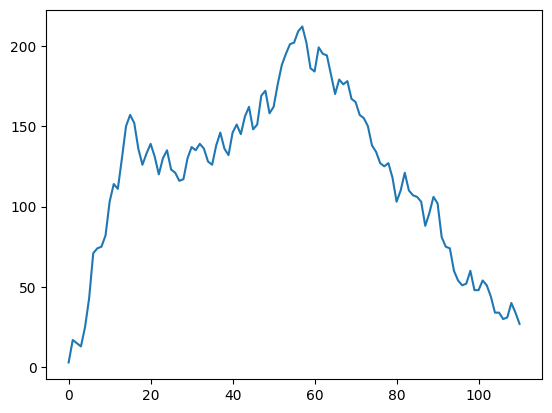

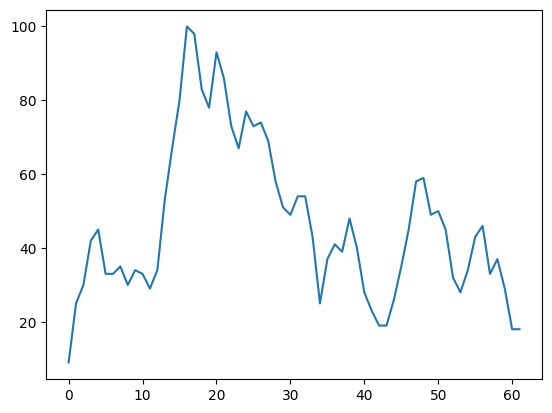

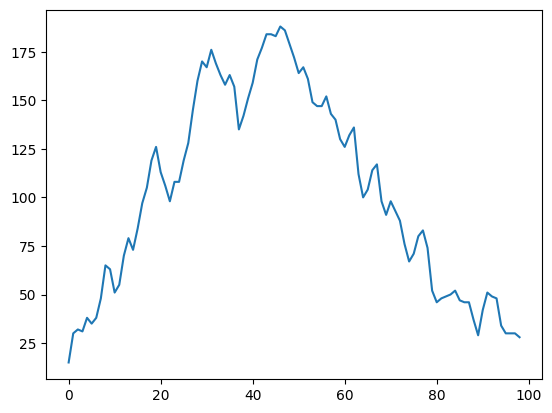

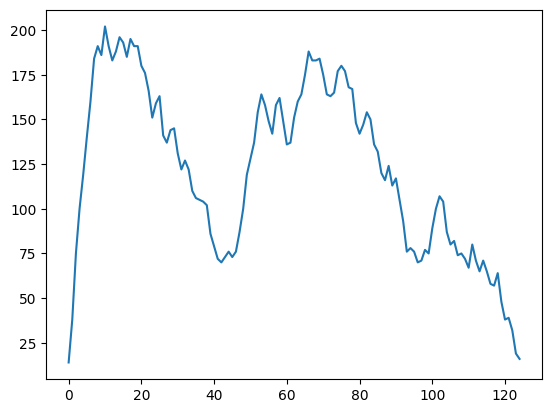

(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)


<ipython-input-16-b085d51e20a8>:14: RuntimeWarning: invalid value encountered in scalar divide
  prompt_fraction.append( np.sum(pr)/ np.sum(ali))


(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)


In [ ]:
filename = '/content/drive/MyDrive/lab_adi/adc_data_run_25036_ch_40_all.npy'
chunk_size = 500
threshold = 100
num_columns = 1150
window_size = 500
output_file = '/content/drive/MyDrive/lab_adi/processed_data_positive.csv'

with open(output_file, 'w') as f:
    pd.DataFrame().to_csv(f, index=False)

for i, chunk in enumerate(load_in_chunks(filename, chunk_size, 1, None)):
    processed_chunk = features_extraction(chunk)
    print(processed_chunk.shape)
    if i == 0:
        processed_chunk.to_csv(output_file, mode='a', header=True, index=False)
    else:
        processed_chunk.to_csv(output_file, mode='a', header=False, index=False)


4200
262144
2599
262144
48
18
21
155
77
23
160
56
28
54
96
22
81
66
9
83
60
40
83
91
71
18
47
56
99
41
44
27
64
114
132
28
33
35
50
71
119
48
123
75
40
23
51
15
50
113
44
121
34
55
46
17
30
43
53
48
4
33
35
18
43
59
63
21
47
38
81
6
69
69
36
30
48
34
162
16
22
56
78
44
52
24
9
46
17
25
40
31
50
37
43
42
13
81
24
53
25
22
25
84
52
41
34
19
26
55
68
1
1
1
13
44
87
80
25
53
54
83
57
38
37
36
63
1
0
26
105
51
12
79
34
11
51
47
74
40
13
38
2
30
24
78
40
28
17
35
43
16
39
61
45
21
33
46
7
29
83
35
63
31
33
46
49
105
66
43
104
61
46
36
25
21
66
111
83
42
67
101
19
54
13
103
43
36
54
31
30
57
52
57
49
43
18
20
11
19
8
72
42
19
20
119
34
75
87
58
68
23
62
9
66
70
58
47
40
122
6
67
33
34
89
72
80
2
52
87
22
13
41
73
58
64
0
40
101
43
67
13
51
36
63
59
24
99
31
8
94
9
101
4
58
46
39
65
84
109
81
118
38
130
26
3
1
68
61
126
51
3
74
90
56
34
36
61
25
9
23
93
26
130
11
21
39
2
65
86
43
104
31
14
20
62
28
36
2
81
112
39
41
70
33
76
56
18
36
56
27
54
26
80
38
21
21
38
58
39
30
63
21
39
30
73
62
41
85


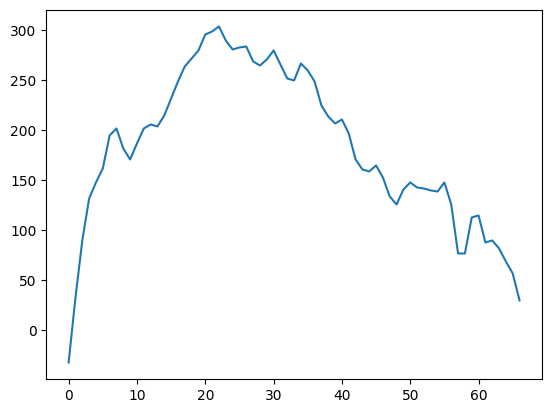

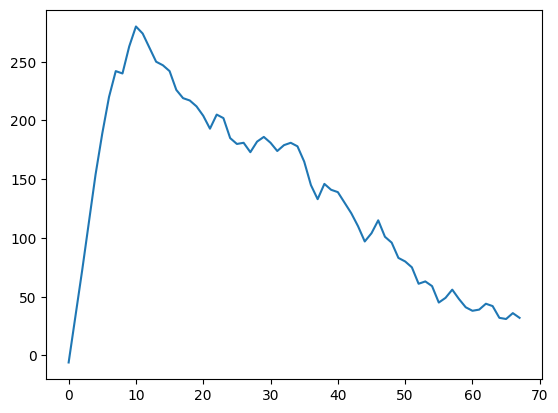

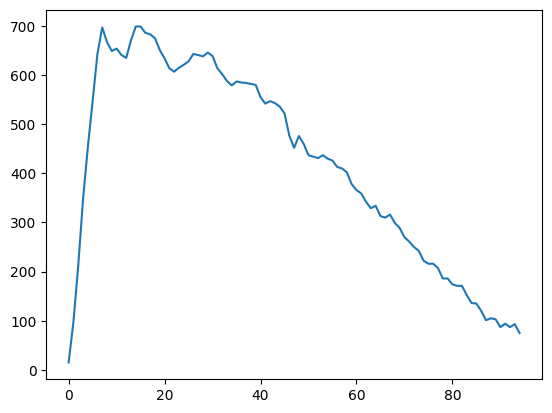

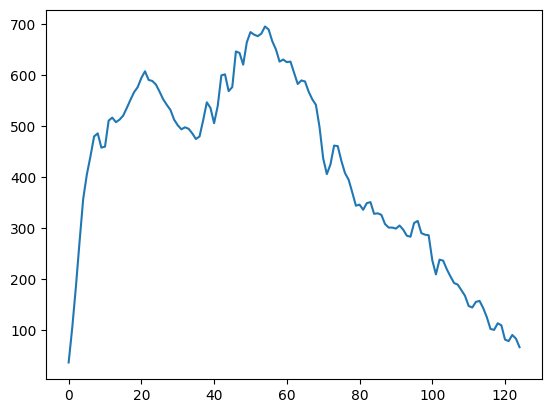

(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)


<ipython-input-16-b085d51e20a8>:14: RuntimeWarning: invalid value encountered in scalar divide
  prompt_fraction.append( np.sum(pr)/ np.sum(ali))


(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(43, 24)


In [ ]:
filename = '/content/drive/MyDrive/lab_adi/adc_data_run_25066_ch_40_all.npy'
chunk_size = 500
num_columns = 1150
threshold = 100
window_size = 500
output_file = '/content/drive/MyDrive/lab_adi/processed_data_negative.csv'

with open(output_file, 'w') as f:
    pd.DataFrame().to_csv(f, index=False)

for i, chunk in enumerate(load_in_chunks(filename, chunk_size, 0, None)):
    processed_chunk = features_extraction(chunk)
    print(processed_chunk.shape)
    if i == 0:
        processed_chunk.to_csv(output_file, mode='a', header=True, index=False)
    else:
        processed_chunk.to_csv(output_file, mode='a', header=False, index=False)

38146
65536
808
65536
2
0
0
0
0
0
0
15
0
0
7
0
3
0
0
1
0
0
0
0
13
0
0
21
0
0
0
0
0
0
0
15
0
0
0
4
4
23
0
16
0
14
0
0
28
0
0
4
0
0
0
0
17
0
0
0
0
0
15
0
0
0
0
0
0
0
0
0
10
0
22
0
0
23
0
31
0
0
12
0
4
0
0
0
0
0
0
0
0
17
0
0
0
13
0
0
0
0
0
0
0
0
20
0
0
0
0
0
28
0
0
0
0
0
0
0
17
0
0
30
0
407
0
0
0
18
11
0
3
0
0
0
21
7
0
22
25
0
3
0
0
0
0
10
11
0
0
0
2
0
0
10
0
0
0
9
0
4
0
0
0
0
0
0
7
0
0
0
21
0
160
0
0
3
0
9
11
0
0
18
0
0
0
0
0
0
5
0
0
0
1
0
20
8
0
2
0
0
0
2
24
399
0
0
0
0
10
16
0
0
0
0
0
0
3
0
0
0
0
2
4
29
0
0
0
20
0
9
16
0
0
0
0
0
0
0
0
0
3
30
4
0
0
0
0
2
0
0
0
358
0
17
0
21
0
0
18
2
0
0
390
15
31
0
19
0
0
0
16
0
33
2
0
0
0
3
0
0
0
0
9
5
0
0
14
0
0
0
28
0
17
4
0
17
0
3
8
0
0
335
0
0
0
17
0
0
0
0
0
0
0
0
0
21
0
0
0
4
0
3
0
17
0
9
0
0
0
0
0
0
2
0
0
0
0
15
0
0
0
20
0
0
0
0
0
0
5
3
0
0
0
0
0
0
0
0
0
5
0
0
0
0
18
9
7
0
0
0
0
1
0
0
1
0
0
0
4
0
6
0
0
0
0
0
0
0
28
5
0
1
0
0
0
0
14
0
0
0
4
0
0
0
19
22
22
3
0
0
4
0
0
0
0
14
0
0
0
27
1
15
0
0
0
4
0
0
0
0
0
0
0
0
0
6
0
0
0
5
20
0
0
0
0
17
5
30
0
20


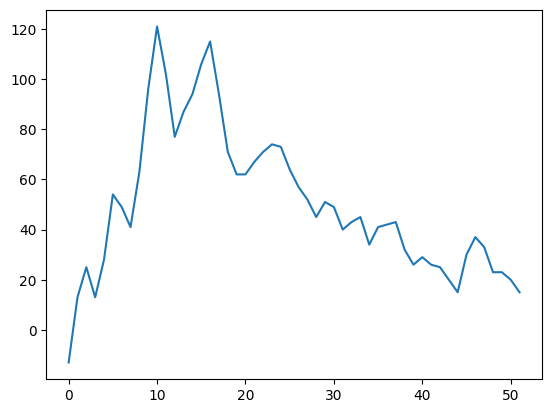

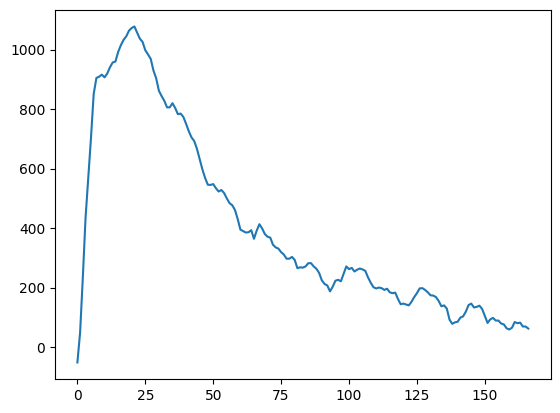

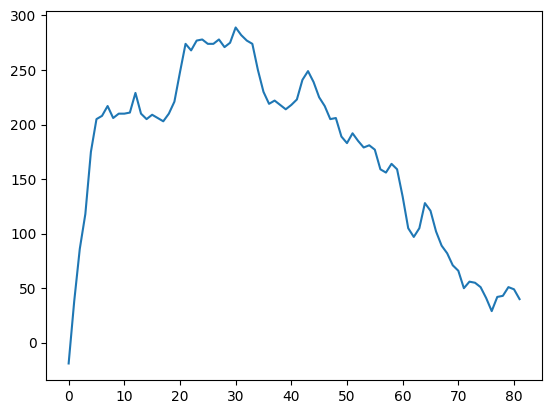

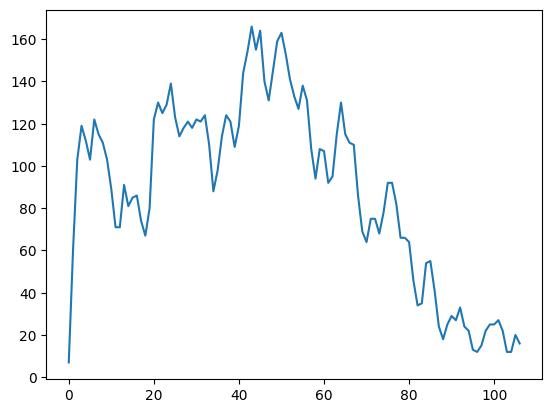

(500, 24)
(500, 24)
(500, 24)
(114, 24)


In [ ]:
filename = '/content/drive/MyDrive/lab_adi/adc_data_run_25071_ch_37_all.npy'
chunk_size = 500
num_columns = 1150
threshold = 100
window_size = 300
output_file = '/content/drive/MyDrive/lab_adi/processed_data_positive.csv'

for i, chunk in enumerate(load_in_chunks(filename, chunk_size, 1, None)):
    processed_chunk = features_extraction(chunk)
    print(processed_chunk.shape)
    processed_chunk.to_csv(output_file, mode='a', header=False, index=False)

8616
65536
146
65536
99
0
27
188
132
83
149
55
90
98
0
33
122
53
88
81
56
77
73
69
37
127
49
89
134
1
51
132
49
97
109
72
108
138
89
88
33
207
15
236
1
37
73
150
77
55
85
83
35
39
84
99
0
89
61
103
46
100
43
41
40
46
133
114
131
108
69
132
107
79
141
159
98
177
145
82
41
100
51
65
61
78
188
41
91
110
70
84
188
46
53
84
29
137
166
44
87
70
167
80
94
2
194
73
0
87
89
33
47
72
172
105
160
72
67
110
26
91
37
57
126
45
94
193
71
176
128
33
8
110
168
12
125
48
0
94
101
37
121
91
141
35
27
59
216
59
113


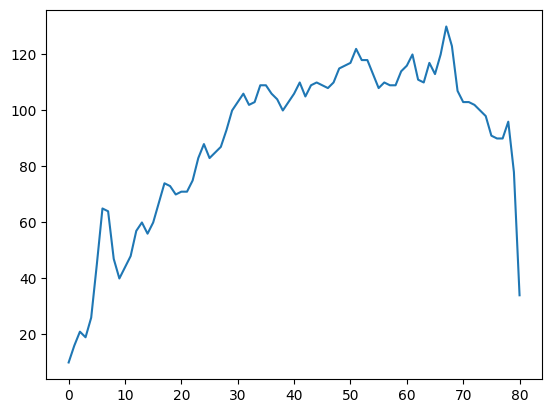

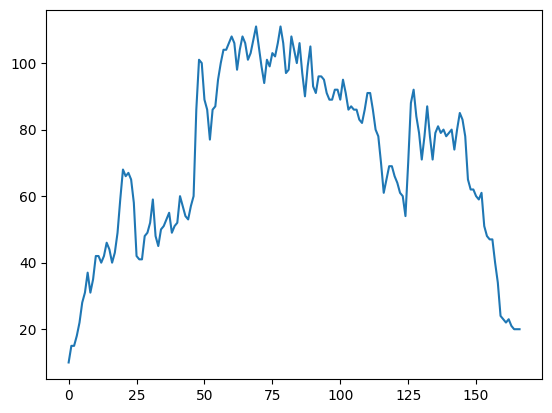

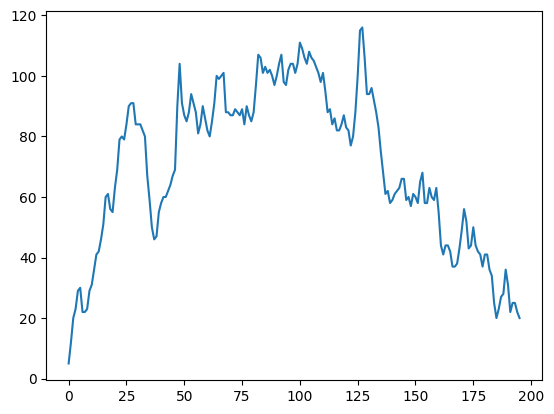

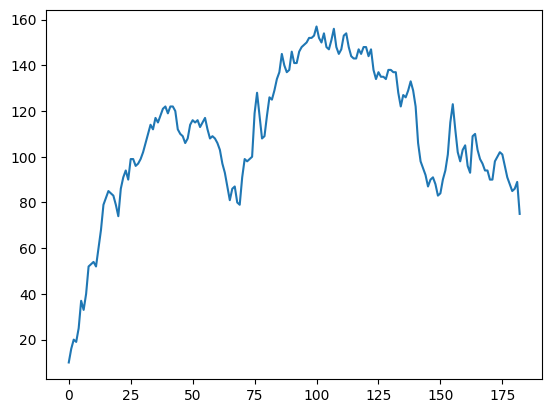

(113, 24)


In [ ]:
filename = '/content/drive/MyDrive/lab_adi/adc_data_run_25050_ch_37_all.npy'
chunk_size = 500
num_columns = 65536
upper_limit = 4200
output_file = '/content/drive/MyDrive/lab_adi/processed_data_positive.csv'

for i, chunk in enumerate(load_in_chunks(filename, chunk_size, 1500, upper_limit)):
    processed_chunk = features_extraction(chunk)
    print(processed_chunk.shape)
    processed_chunk.to_csv(output_file, mode='a', header=False, index=False)

4462
262144
142
262144
108
62
151
64
161
58
84
81
108
125
31
108
60
82
81
137
61
53
93
99
92
162
96
21
71
72
118
125
22
143
18
91
145
93
33
27
92
53
88
90
37
98
42
159
38
65
81
93
85
35
30
123
83
144
79
35
62
114
109
50
14
93
83
62
54
34
113
45
91
114
85
92
57
54
113
63
69
63
68
112
132
117
121
42
136
151
54
114
164
180
86
45
60
51
140
61
105
67
96
143
7
32
33
81
69
141
72
78
166
54
181
125
138
53
143
166
53
75
63
136
31
155
49
29
73
77
110
131
42
87
99
24
118
98
133
103
40
13
74
136
79
111
6629


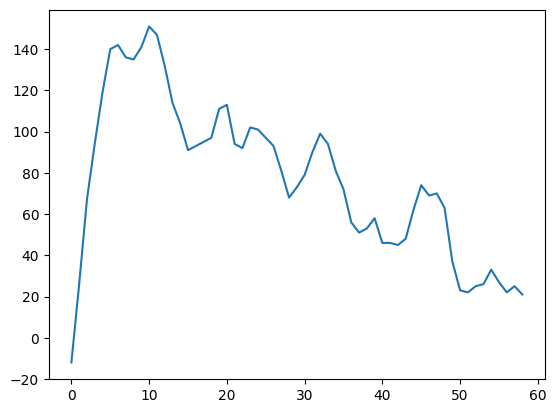

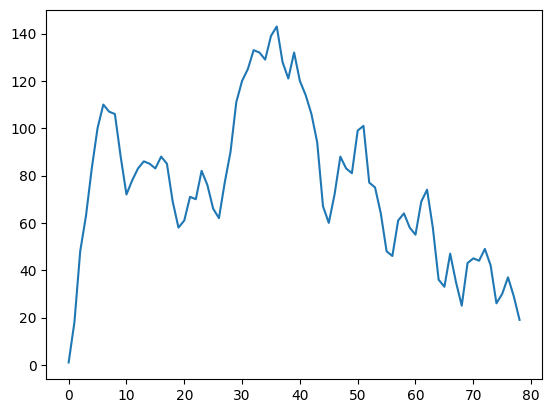

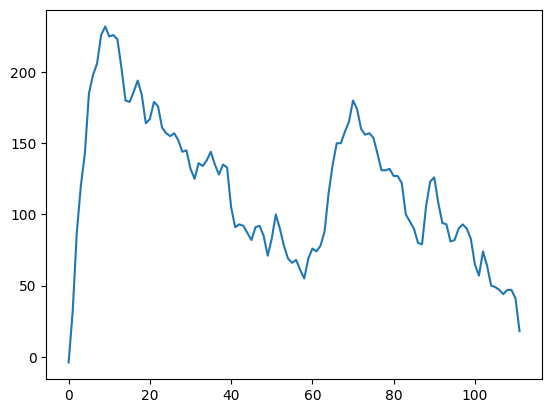

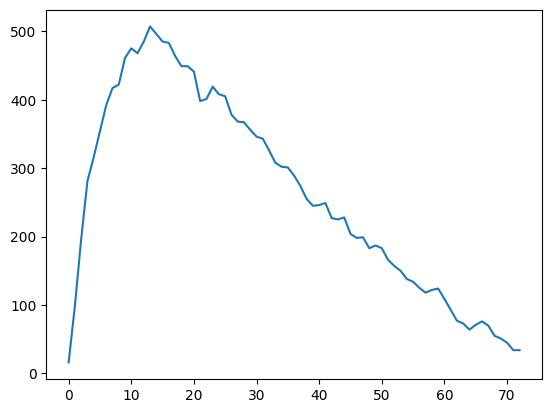

(500, 24)
(500, 24)


<ipython-input-16-b085d51e20a8>:14: RuntimeWarning: invalid value encountered in scalar divide
  prompt_fraction.append( np.sum(pr)/ np.sum(ali))


(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(500, 24)
(129, 24)


In [ ]:
filename = '/content/drive/MyDrive/lab_adi/adc_data_run_25087_ch_37_all.npy'
chunk_size = 500
num_columns = 1150
threshold = 100
window_size = 300
output_file = '/content/drive/MyDrive/lab_adi/processed_data_negative.csv'

for i, chunk in enumerate(load_in_chunks(filename, chunk_size, 0, None)):
    processed_chunk = features_extraction(chunk)
    print(processed_chunk.shape)
    processed_chunk.to_csv(output_file, mode='a', header=False, index=False)

In [ ]:
output_file_pos = '/content/drive/MyDrive/lab_adi/processed_data_positive.csv'
output_file_neg = '/content/drive/MyDrive/lab_adi/processed_data_negative.csv'

positive_df_features = pd.read_csv(output_file_pos).fillna(0)
negative_df_features = pd.read_csv(output_file_neg).fillna(0)

print(positive_df_features.shape)
print(negative_df_features.shape)

(74834, 24)
(75672, 24)


In [ ]:
negative_df_features = negative_df_features.iloc[0:positive_df_features.shape[0],:]
print(positive_df_features.shape)
print(negative_df_features.shape)

(74834, 24)
(74834, 24)


In [ ]:
positive_df_features = positive_df_features.drop([ 'Diff_All',
    'Plus_All', 'Mult_All'], axis=1)
negative_df_features = negative_df_features.drop([ 'Diff_All',
    'Plus_All', 'Mult_All'], axis=1)
positive_df_features = positive_df_features.drop([ 'Promptv_3',
    'PromptFraction_3', 'PeakPrompt_3'], axis=1)
negative_df_features = negative_df_features.drop([ 'Promptv_3',
    'PromptFraction_3', 'PeakPrompt_3'], axis=1)
positive_df_features = positive_df_features.drop([ 'Promptv_2',
    'PromptFraction_2', 'PeakPrompt_2'], axis=1)
negative_df_features = negative_df_features.drop([ 'Promptv_2',
    'PromptFraction_2', 'PeakPrompt_2'], axis=1)
negative_df_features = negative_df_features.drop([ 'PromptFraction_Peak_Dif',
    'PromptFraction_vPrompt_Dif', 'Peak_vPrompt_Dif'], axis=1)
positive_df_features = positive_df_features.drop([ 'PromptFraction_Peak_Dif',
    'PromptFraction_vPrompt_Dif', 'Peak_vPrompt_Dif'], axis=1)
# negative_df_features = negative_df_features.drop([ 'PromptFraction',
#     'PeakPrompt', 'V_PROMPT'], axis=1)
# positive_df_features = positive_df_features.drop([ 'PromptFraction',
#     'PeakPrompt', 'V_PROMPT'], axis=1)
negative_df_features = negative_df_features.drop([ 'PromptFraction_Peak_Plus',
    'PromptFraction_vPrompt_Plus', 'Peak_vPrompt_Plus'], axis=1)
positive_df_features = positive_df_features.drop([ 'PromptFraction_Peak_Plus',
    'PromptFraction_vPrompt_Plus', 'Peak_vPrompt_Plus'], axis=1)
negative_df_features = negative_df_features.drop([ 'PromptFraction_Var',
    'vPrompt_Var', 'Peak_Var'], axis=1)
positive_df_features = positive_df_features.drop([ 'PromptFraction_Var',
    'vPrompt_Var', 'Peak_Var'], axis=1)
negative_df_features = negative_df_features.drop([ 'PromptFraction_Peak_Mult', 'PromptFraction_vPrompt_Mult', 'Peak_vPrompt_Mult'], axis=1)
positive_df_features = positive_df_features.drop([ 'PromptFraction_Peak_Mult',
     'PromptFraction_vPrompt_Mult', 'Peak_vPrompt_Mult'], axis=1)

In [ ]:
X = np.concatenate((positive_df_features.values, negative_df_features.values), axis=0)
y = np.array([1]*len(positive_df_features) + [0]*len(negative_df_features))

In [ ]:
print(f"X.shape={X.shape}")
print(f"y.shape={y.shape}")

X.shape=(63167, 3)
y.shape=(63167,)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
print(f"len positive = {len(positive_df_features)}")
print(f"len negative = {len(negative_df_features)}")

len positive = 32202
len negative = 30965


In [ ]:
def Train(max_depth, min_samples):
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)

  # Initialize the classifier
  clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_split = min_samples, min_samples_leaf=min_samples)

  # Train the classifier
  clf.fit(X_train, y_train)

  # Make predictions
  y_pred = clf.predict(X_test)

  # Evaluate the model
  accuracy = accuracy_score(y_test, y_pred)

  #report = classification_report(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  return accuracy, recall, f1, precision

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

tree_depths = np.arange(5, 71)
min_samples_splits_leaf = np.arange(2, 21)

xaxis, yaxis = np.meshgrid(tree_depths, min_samples_splits_leaf)

accuracy_vals = np.zeros_like(xaxis, dtype=float)
recall_vals = np.zeros_like(xaxis, dtype=float)
f1_vals = np.zeros_like(xaxis, dtype=float)
precision_vals = np.zeros_like(xaxis, dtype=float)

for i in range(xaxis.shape[0]):
    for j in range(xaxis.shape[1]):
        print(Train(xaxis[i, j], yaxis[i, j]))
        accuracy_vals[i, j], recall_vals[i,j], f1_vals[i,j], precision_vals[i,j]= Train(xaxis[i, j], yaxis[i, j])

fig = plt.figure(figsize=(10, 12))
fig.suptitle("Accuracy and F1 vs. Tree Depth and Minimum Samples", fontsize=15)
ax1 = fig.add_subplot(211, projection='3d')
scatter1 = ax1.scatter(xaxis, yaxis, accuracy_vals, c=accuracy_vals, cmap='viridis', s=1)
cbar1 = fig.colorbar(scatter1, ax=ax1, pad=0.1)
cbar1.set_label('Accuracy')
ax1.set_xlabel('Maximum tree depth')
ax1.set_ylabel('Minimum Samples per Leaf and Split')
ax1.set_zlabel('Accuracy')
ax1.set_title('Accuracy')

ax2 = fig.add_subplot(212, projection='3d')
scatter2 = ax2.scatter(xaxis, yaxis, f1_vals, c=f1_vals, cmap='viridis', s=1)
cbar2 = fig.colorbar(scatter2, ax=ax2, pad=0.1)
cbar2.set_label('F1')
ax1.set_xlabel('Maximum tree depth')
ax1.set_ylabel('Minimum Samples per Leaf and Split')
ax1.set_zlabel('F1')
ax2.set_title('F1')

plt.subplots_adjust(hspace=0.61)
plt.subplots_adjust(wspace=0.61)
plt.show()

fig2 = plt.figure(figsize=(10, 12))
fig2.suptitle("Precision and Recall vs. Tree Depth and Minimum Samples", fontsize=15)
ax3 = fig2.add_subplot(211, projection='3d')
scatter3 = ax3.scatter(xaxis, yaxis, recall_vals, c=recall_vals, cmap='viridis', s=1)
cbar3 = fig2.colorbar(scatter3, ax=ax3, pad=0.1)
cbar3.set_label('Recall')
ax3.set_xlabel('Maximum tree depth')
ax3.set_ylabel('Minimum Samples per Leaf and Split')
ax3.set_zlabel('Recall')
ax3.set_title('Recall')

ax4 = fig2.add_subplot(212, projection='3d')
scatter4 = ax4.scatter(xaxis, yaxis, precision_vals, c=precision_vals, cmap='viridis', s=1)
cbar2 = fig2.colorbar(scatter4, ax=ax4, pad=0.1)
cbar2.set_label('Precision')
ax1.set_xlabel('Maximum tree depth')
ax1.set_ylabel('Minimum Samples per Leaf and Split')
ax1.set_zlabel('Precision')
ax2.set_title('Precision')

plt.subplots_adjust(hspace=0.61)
plt.subplots_adjust(wspace=0.61)
plt.show()

(0.5705239829032769, 0.7380237972064149, 0.6367328721267574, 0.5598901098901099)
(0.5734789720859057, 0.6952086553323029, 0.6253881447837976, 0.5683119946091644)
(0.5773837792200939, 0.6865210222588624, 0.624572258941546, 0.5728781494539513)
(0.5783863648356288, 0.6964895930413172, 0.6273668501072661, 0.5707254985150615)
(0.5844018785288375, 0.7112487100103199, 0.6363804247460757, 0.5757727652464495)
(0.5849295551685927, 0.6829014465605162, 0.6252501191043354, 0.5765749934100695)
(0.5832409899213762, 0.652573909448005, 0.6151822256870005, 0.5818433179723502)
(0.5947443406680386, 0.6851081530782029, 0.6317606444188723, 0.5861209964412811)
(0.5939528257084059, 0.655226371792197, 0.6201313126326702, 0.5886046293693187)
(0.596116299931402, 0.6565355786014991, 0.6255747969865962, 0.5974025974025974)


KeyboardInterrupt: 

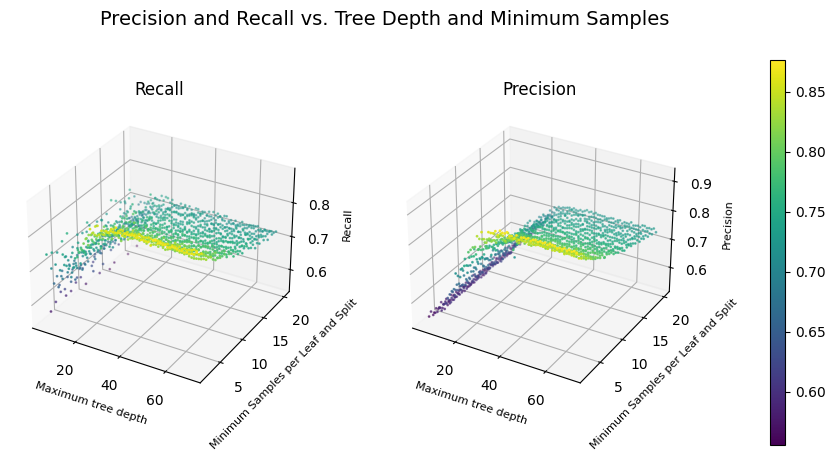

In [ ]:
import matplotlib.gridspec as gridspec

gs2 = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05])

fig2 = plt.figure(figsize=(10, 5))
fig2.suptitle("Precision and Recall vs. Tree Depth and Minimum Samples", fontsize=14)
ax3 = fig2.add_subplot(gs2[0], projection='3d')
sc3 = ax3.scatter(xaxis, yaxis, recall_vals, c=recall_vals, cmap='viridis', s=1)
ax3.set_xlabel('Maximum tree depth', fontsize=8)
ax3.set_ylabel('Minimum Samples per Leaf and Split', fontsize=8)
ax3.set_zlabel('Recall', fontsize=8)
ax3.set_title('Recall')

ax4 = fig2.add_subplot(gs2[1], projection='3d')
scatter4 = ax4.scatter(xaxis, yaxis, precision_vals, c=precision_vals, cmap='viridis', s=1)
ax4.set_xlabel('Maximum tree depth', fontsize=8)
ax4.set_ylabel('Minimum Samples per Leaf and Split', fontsize=8)
ax4.set_zlabel('Precision', fontsize=8)
ax4.set_title('Precision')

cbar_ax = fig2.add_subplot(gs2[2])
fig2.colorbar(sc3, cax=cbar_ax)

plt.subplots_adjust(wspace=0.4)  # Adjust the space between plots
plt.show()


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)

# Initialize the classifier
clf = DecisionTreeClassifier(max_depth=30)
clf.fit(X_train, y_train)

# Make predictions
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Classification Report:\n", report)

Accuracy: 0.6855047227059258
Precision: 0.6918304033092038
Recall: 0.6918304033092038
F1 Score: 0.6918304033092038
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.68      0.68      9281
           1       0.69      0.69      0.69      9670

    accuracy                           0.69     18951
   macro avg       0.69      0.69      0.69     18951
weighted avg       0.69      0.69      0.69     18951



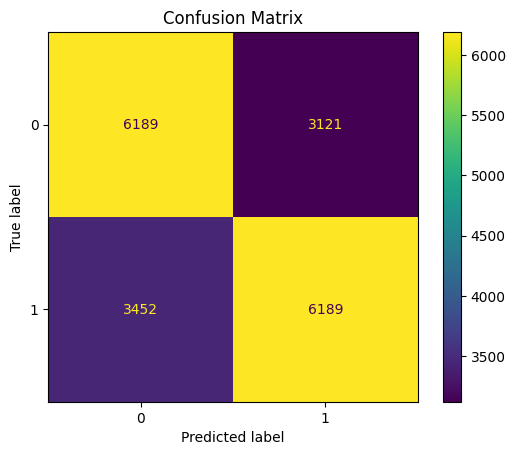

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

Feature: $F_{p}$ by Peak Width, Importance: 0.3293524249462546
Feature: $F_{p}$ Around Maxima, Importance: 0.34594710878817014
Feature: $F_{p}$ by Predifined Margins, Importance: 0.32470046626557525


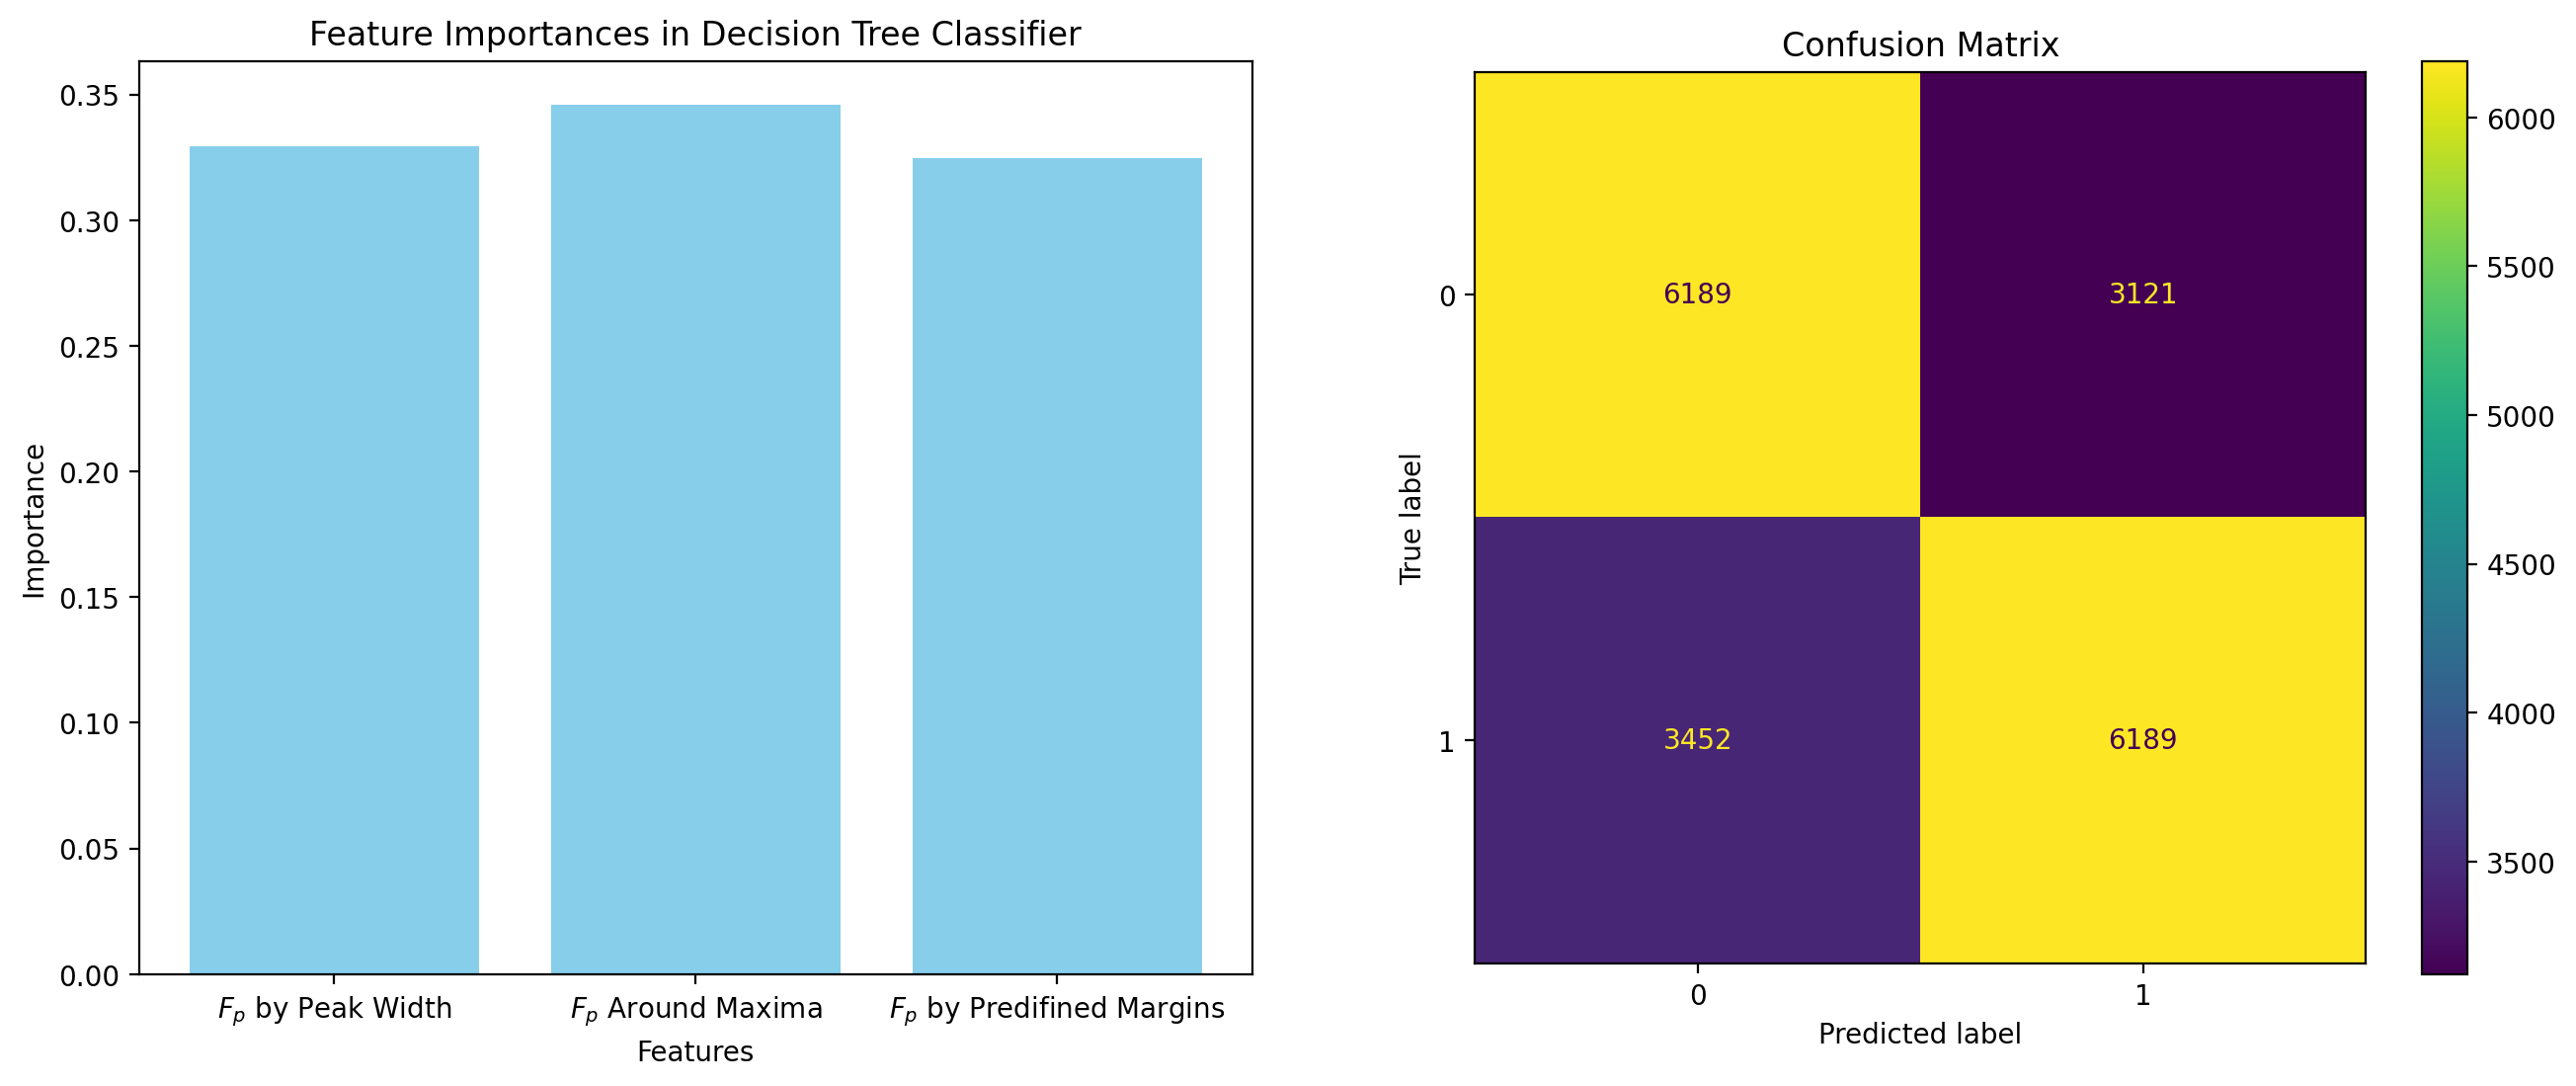

In [ ]:
# Get feature importances
feature_importances = clf.feature_importances_
feature_names = ['$F_{p}$ by Peak Width', '$F_{p}$ Around Maxima', '$F_{p}$ by Predifined Margins']
# Print feature importances
for feature, importance in zip(feature_names, feature_importances):
    print(f"Feature: {feature}, Importance: {importance}")

# Optionally, plot the feature importances
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16, 6], dpi=200)

ax1.bar(feature_names, feature_importances, color='skyblue')
ax1.set_xlabel('Features')
ax1.set_ylabel('Importance')
ax1.set_title('Feature Importances in Decision Tree Classifier')

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot(ax=ax2)
ax2.set_title("Confusion Matrix")
plt.show()


In [ ]:
data = {'X': np.concatenate([positive_df_features['PromptFraction'].values, negative_df_features['PromptFraction'].values]),
        'Y': np.concatenate([positive_df_features['PeakPrompt'].values, negative_df_features['PeakPrompt'].values]),
        'Z': np.concatenate([positive_df_features['V_PROMPT'].values, negative_df_features['V_PROMPT'].values])}
df = pd.DataFrame(data)

# Calculate correlation matrix
correlation_matrix = df.corr()
print(correlation_matrix)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from mpl_toolkits.mplot3d import Axes3D



In [ ]:
#Another attempt to visualize the tree's partition of parameter space.
top_features = ['V_PROMPT', 'PromptFraction', 'PeakPrompt']
selected_features_indices = [positive_df_features.columns.get_loc(par) for par in top_features]

param1_values = np.linspace(0, 1, 8)
param2_values = np.linspace(0, 1, 8)
param3_values = np.linspace(0, 1, 8)

param1_grid, param2_grid, param3_grid = np.meshgrid(param1_values, param2_values, param3_values)

param1_flat = param1_grid.flatten()
param2_flat = param2_grid.flatten()
param3_flat = param3_grid.flatten()

randomized_other_params = np.array([np.random.choice(X_test[:, i], size=len(param1_flat)) for i in range(X_test.shape[1]) if i not in [selected_features_indices[0], selected_features_indices[1], selected_features_indices[2]]]).T

X_new = np.column_stack([param1_flat, param2_flat, param3_flat, randomized_other_params])

y_pred_new = clf.predict(X_new)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(param1_flat, param2_flat, param3_flat, c=y_pred_new, cmap='bwr', alpha=0.2)

ax.set_xlabel(top_features[0])
ax.set_ylabel(top_features[1])
ax.set_zlabel(top_features[2])
plt.title('3D Classification Boundary with Top 3 Features')
plt.show()

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
tree.plot_tree(clf, feature_names=positive_df_features.columns, class_names=["Class 0", "Class 1"], filled=True)
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score, KFold

# Perform cross-validation
cv = KFold(n_splits=5, shuffle=True)
cv_scores = cross_val_score(clf, X_scaled, y, cv=cv)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [0.81452529 0.79935859 0.79621835 0.79681288 0.80710253]
Mean cross-validation score: 0.802803527195905


In [ ]:
print("Tree depth:", clf.get_depth())
print("Number of leaves:", clf.get_n_leaves())

Tree depth: 25
Number of leaves: 7969


**How to log into DUNE machine from windows and extract runs:**

1. install MIT kerberos.
2. Log into the university VPN.
3. Then, click "get ticket" in MIT kerberos. Use the following principal: [your_username]@FNAL.GOV (must be uppercase), with the password you received from Fermilab (contact helpdesk for it).
4. Install putty.
5. In putty, get to SSH - Auth- GSSAPI, mark all checkboxes.
6. Log into [your_username]@dunegpvmXX.fnal.gov (replace XX with machine number, I think it goes from 01 to 11).
7. Runs are in /pnfs/dune/tape_backed/dunepro/vd-coldbox/raw/2024/detector/
For example run 25050 files are in (/pnfs/dune/tape_backed/dunepro/vd-coldbox/raw/2024/detector/cosmics/None/00/02/50/50)
8. Instructions on how to set the environment are in https://github.com/weishi10141993/VDPDSAna/blob/main/PNSCali/CaliSim.md#generate-gamma-cascades.
9. use the  dump_pds_ana_info.py file from my directory ("ggonen") in the following manner for the desired runs:
 dump_pds_ana_info.py /pnfs/dune/tape_backed/dunepro/vd-coldbox/raw/2024/detector/cosmics/None/00/02/50/66/ 25066

 since the run files are really big, there will be several .npy file generated for each run, divided to chunks (if you run into a memory problem, change the chunck size in dump_pds_ana_info.py). Then use winSCP to comfortably transfer all .npy files to your computer, and generate using gpt a simple python code to unite them to one npy file.
